# Test PTMCMC sampler

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from no_jax_ptmcmc import PTMCMC


## Sample multivariate normal distribution

In [2]:
# dimension of normal distribution
ndim = 6

# bounds and labels for parameters
x_mins = np.array([-10.0] * ndim)
x_maxs = np.array([10.0] * ndim)
x_labels = np.array([rf'$x_{{{i + 1}}}$' for i in range(ndim)])

# choose moments of normal distribution
np.random.seed(0)
mean = np.random.uniform(x_mins / 2., x_maxs / 2.)
normal = np.random.normal(size=ndim)
cov = np.outer(normal, normal) + np.eye(ndim) * 0.01

# get log-pdf of distribution
scipy_mv_logpdf = multivariate_normal(mean=mean, cov=cov).logpdf
def mv_logpdf(x, temperature=1.0):
    return scipy_mv_logpdf(x) / temperature

In [3]:
# sample with PTMCMC
num_samples = int(5e5)
num_chains = 10
samples, logpdfs, temperature_ladder = PTMCMC(num_samples=num_samples,
                                              num_chains=num_chains,
                                              logpdf_func=mv_logpdf,
                                              ndim=ndim,
                                              param_mins=x_mins,
                                              param_maxs=x_maxs)

/Users/aidengundersen/Desktop/miscMCMC/samplers/no_jax_ptmcmc.py:104: RuntimeWarning: overflow encountered in exp
  acc_probs = np.exp(lnlike_proposals - lnlikes[:, i])


jump acceptance rates:
Fisher = [0.296 0.342 0.39  0.441 0.495 0.549 0.601 0.652 0.701 0.745]

DE = [0.39  0.448 0.505 0.547 0.588 0.631 0.66  0.697 0.718 0.748]

PT = [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]



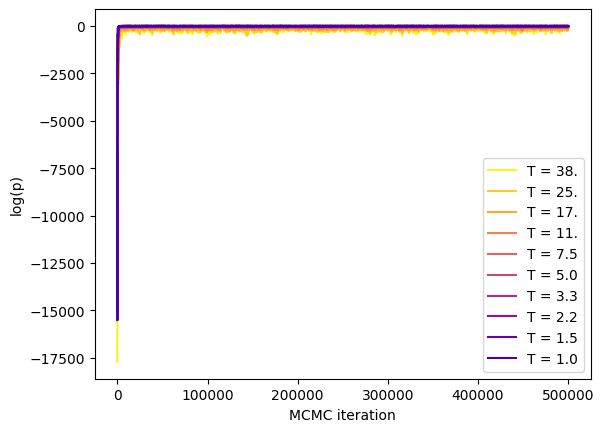

In [4]:
# plot log-pdf values
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))

for j, (temp, color) in enumerate(zip(temperature_ladder[::-1], chain_colors)):
    plt.plot(logpdfs[::-1][j] * temp, color=color, label=f'T = {str(temp)[:3]}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(p)')
plt.legend(loc='lower right')
plt.show()

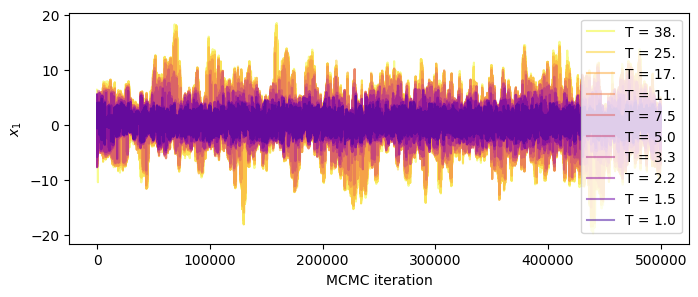

In [5]:
# make trace plot for particular parameter
param_ndx = 0
plt.figure(figsize=(8, 3))
for j in range(num_chains - 1, -1, -1):
    plt.plot(samples[j, :, param_ndx], color=chain_colors[::-1][j], alpha=0.5,
             label=f'T = {str(temperature_ladder[j])[:3]}')
plt.legend()
plt.xlabel('MCMC iteration')
plt.ylabel(f'{x_labels[param_ndx]}')
plt.show()

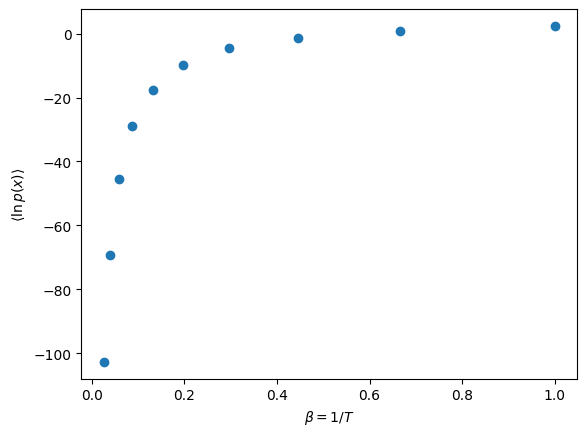

In [6]:
# plot average logpdf values
burnin = num_samples // 2
betas = 1. / temperature_ladder
avg_lnlikes = np.mean(logpdfs[:, burnin::10], axis=1) * temperature_ladder
plt.scatter(betas, avg_lnlikes)
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle \ln p(x) \rangle$')
plt.show()

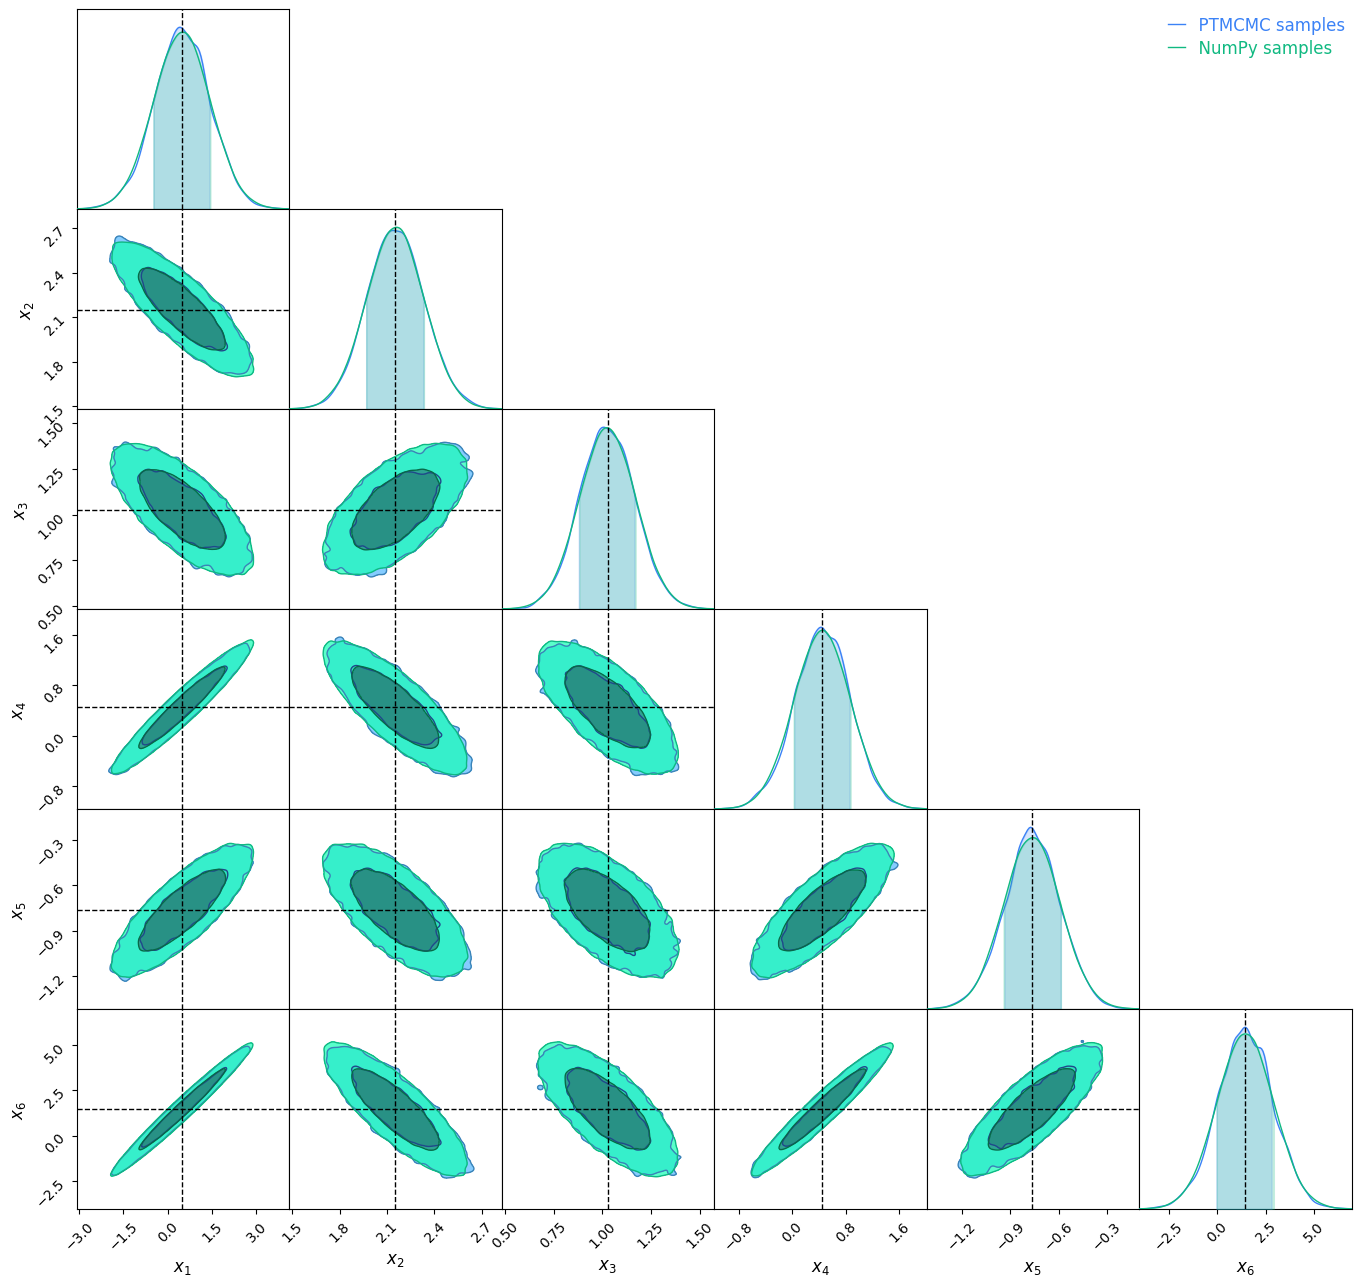

In [7]:
# draw from multivariate normal distribution with NumPy to compare
np_samples = np.random.multivariate_normal(mean, cov, 100_000)

# plot distribution
mv_df = pd.DataFrame(samples[0, burnin::10], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=mv_df, name='PTMCMC samples'))
c.add_chain(Chain(samples=pd.DataFrame(np_samples, columns=x_labels), name='NumPy samples'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, mean)}))
fig = c.plotter.plot()

## Sample uniform distribution

In [8]:
# uniform prior
def ln_uniform(params, temperature=1.0):
    if np.any(params < x_mins) or np.any(params > x_maxs):
        return -np.inf
    else:
        return 0.0

In [9]:
# sample with PTMCMC
# set Fisher jump weight to zero because uniform distribution has no Hessian
# use more samples / chains because uniform distribution has large volume
num_samples = int(1e6)
num_chains = 20
samples, logpdfs, temperature_ladder = PTMCMC(num_samples=num_samples,
                                              num_chains=num_chains,
                                              logpdf_func=ln_uniform,
                                              ndim=ndim,
                                              param_mins=x_mins,
                                              param_maxs=x_maxs,
                                              Fisher_weight=0)

jump acceptance rates:
Fisher = [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]

DE = [0.411 0.413 0.409 0.41  0.411 0.411 0.412 0.415 0.412 0.407 0.408 0.412
 0.411 0.416 0.41  0.409 0.411 0.411 0.406 0.413]

PT = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]



/Users/aidengundersen/Desktop/miscMCMC/samplers/no_jax_ptmcmc.py:141: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


Parameter $x_{1}$ in chain PTMCMC samples is not constrained
Parameter $x_{1}$ in chain NumPy samples is not constrained
Parameter $x_{2}$ in chain PTMCMC samples is not constrained
Parameter $x_{2}$ in chain NumPy samples is not constrained
Parameter $x_{3}$ in chain PTMCMC samples is not constrained
Parameter $x_{3}$ in chain NumPy samples is not constrained
Parameter $x_{4}$ in chain PTMCMC samples is not constrained
Parameter $x_{4}$ in chain NumPy samples is not constrained
Parameter $x_{5}$ in chain PTMCMC samples is not constrained
Parameter $x_{5}$ in chain NumPy samples is not constrained
Parameter $x_{6}$ in chain PTMCMC samples is not constrained
Parameter $x_{6}$ in chain NumPy samples is not constrained


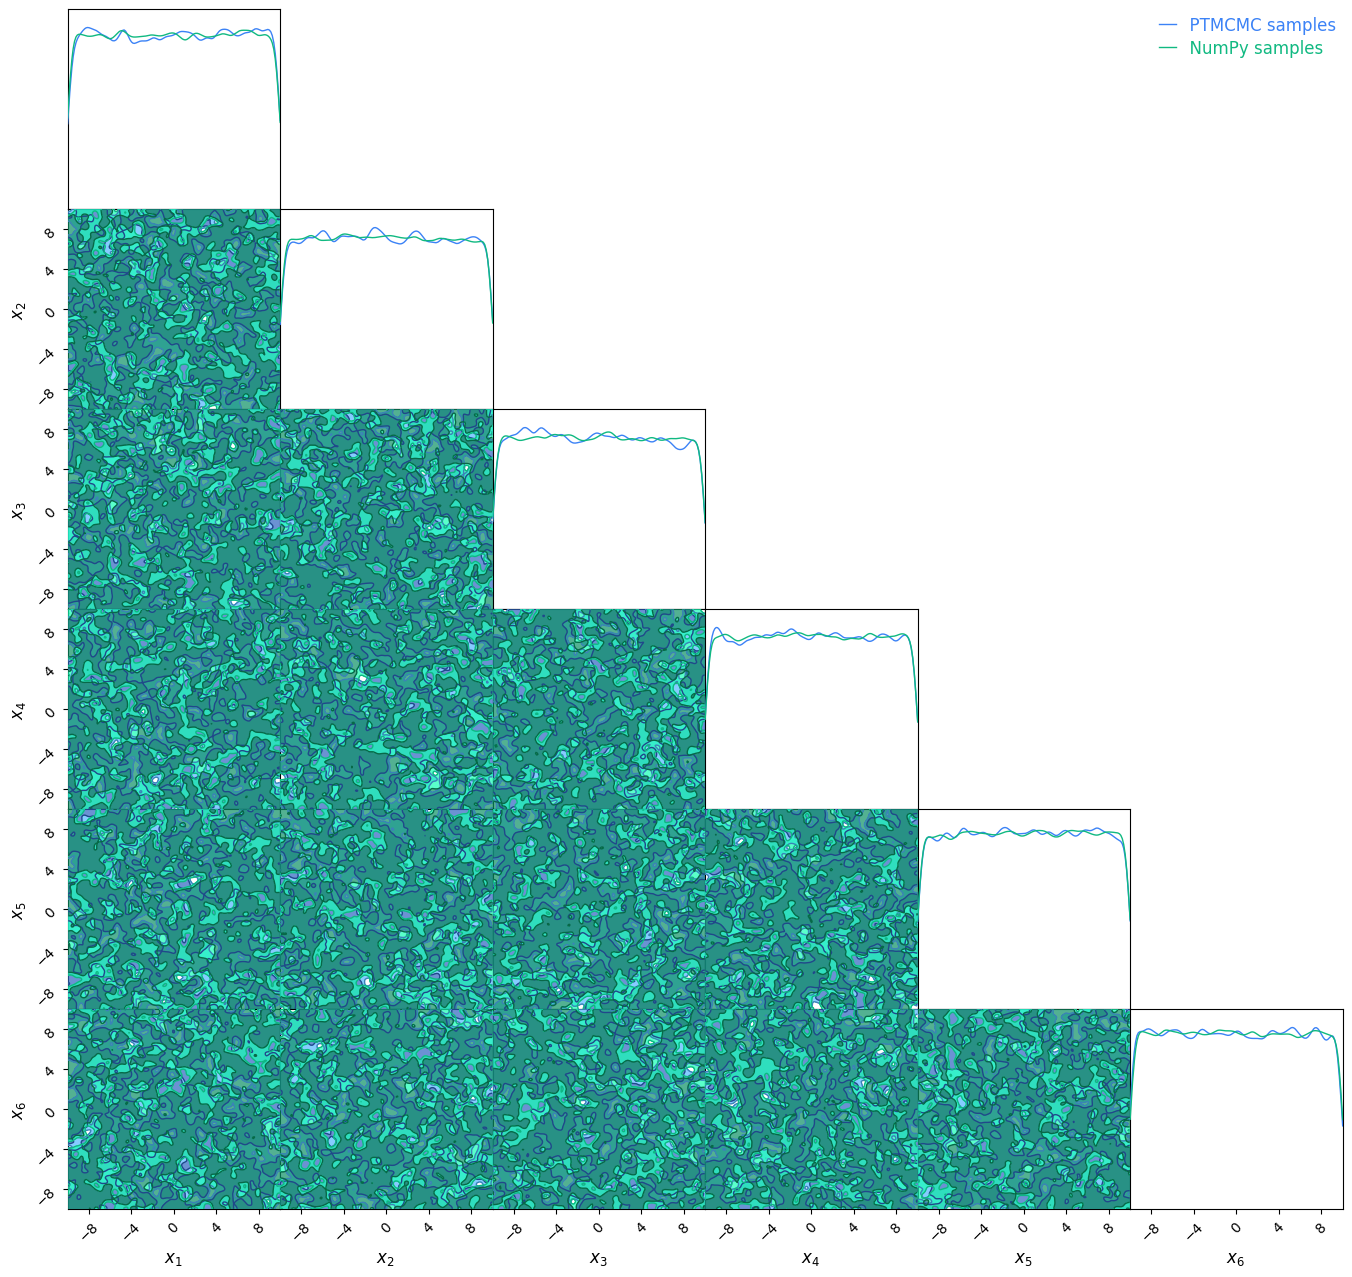

In [10]:
# draw from uniform distribution with NumPy to compare
np_samples = np.random.uniform(x_mins, x_maxs, (100_000, ndim))

# plot distributions
uniform_df = pd.DataFrame(samples[0, burnin::10], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=uniform_df, name='PTMCMC samples'))
c.add_chain(Chain(samples=pd.DataFrame(np_samples, columns=x_labels), name='NumPy samples'))
fig = c.plotter.plot()

## Sample from multimodal distribution

In [11]:
# parameter bounds
param_mins = np.array([-100., -100.])
param_maxs = np.array([100., 100.])
ndim = param_mins.shape[0]

# log-pdf of multimodal distribution
def multmodal_logpdf(params, temperature=1.0):
    # check if parameters are in allowed domain
    if np.any(params < param_mins) or np.any(params > param_maxs):
        return -np.inf
    else:
        # unpack parameters
        x, y = params
        # multimodal density
        logpdf = np.log(16/(3*np.pi)*(np.exp(-x**2-(9+4*x**2+8*y)**2)+1/2*np.exp(-8*x**2-8*(y-2)**2)))
    return logpdf / temperature

In [12]:
# do PTMCMC
num_samples = int(5e5)
num_chains = 10
samples, lnlikes, temperature_ladder = PTMCMC(num_samples=num_samples,
                                              num_chains=num_chains,
                                              logpdf_func=multmodal_logpdf,
                                              ndim=ndim,
                                              param_mins=param_mins,
                                              param_maxs=param_maxs,
                                              Fisher_weight=20,
                                              DE_weight=10,
                                              PT_swap_weight=20)

/var/folders/66/w_x_69897j7fl6qw22pxkywc0000gn/T/ipykernel_40333/1341378992.py:15: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(16/(3*np.pi)*(np.exp(-x**2-(9+4*x**2+8*y)**2)+1/2*np.exp(-8*x**2-8*(y-2)**2)))
/Users/aidengundersen/Desktop/miscMCMC/samplers/no_jax_ptmcmc.py:59: RuntimeWarning: invalid value encountered in scalar subtract
  hessian[i, j] = hessian[j, i] = (fpp - fmp - fpm + fmm) / (4. * epsilon**2.)
/Users/aidengundersen/Desktop/miscMCMC/samplers/no_jax_ptmcmc.py:121: RuntimeWarning: invalid value encountered in scalar add
  log_acc_ratio += log_Ls[swap_map[swap_chain + 1]] / temperature_ladder[swap_chain]
/Users/aidengundersen/Desktop/miscMCMC/samplers/no_jax_ptmcmc.py:104: RuntimeWarning: invalid value encountered in subtract
  acc_probs = np.exp(lnlike_proposals - lnlikes[:, i])
/Users/aidengundersen/Desktop/miscMCMC/samplers/no_jax_ptmcmc.py:122: RuntimeWarning: invalid value encountered in scalar add
  log_acc_ratio += log_Ls[swap_map[swap_chain

jump acceptance rates:
Fisher = [0.604 0.612 0.629 0.672 0.692 0.702 0.706 0.716 0.723 0.733]

DE = [0.202 0.231 0.254 0.281 0.306 0.332 0.358 0.393 0.423 0.467]

PT = [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]



Parameter y in chain T = 1.0 is not constrained
Parameter y in chain T = 5.0 is not constrained


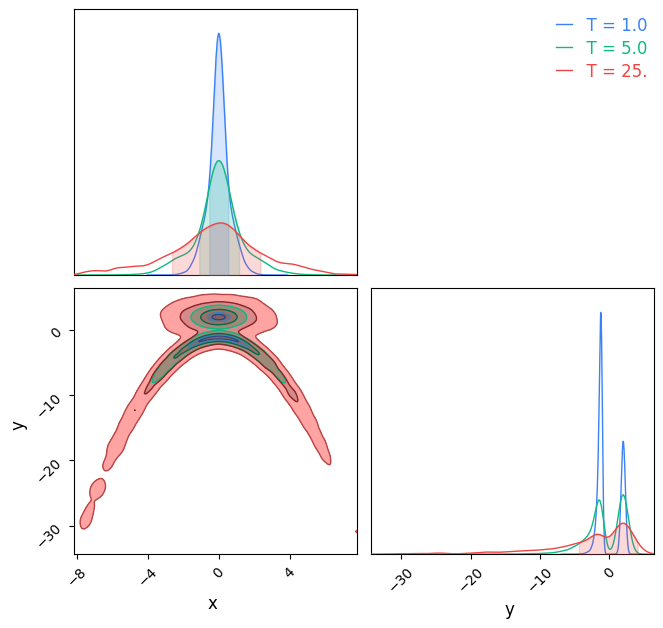

In [13]:
# plot multimodal distribution (at multiple temperatures)
chain_ndxs_to_plot = np.r_[:num_chains][::4]
burnin = num_samples // 10
dfs = [pd.DataFrame(samples[ndx, burnin::10], columns=['x','y'])
       for ndx in chain_ndxs_to_plot]
temps = [temperature_ladder[ndx] for ndx in chain_ndxs_to_plot]
c = ChainConsumer()
for ii, (df, temp) in enumerate(zip(dfs, temps)):
    c.add_chain(Chain(samples=df, name=f'T = {str(temp)[:3]}'))
fig = c.plotter.plot()

# Test JAX-ified PTMCMC

In [14]:
from jax import jit
from jax.scipy.stats import multivariate_normal as jax_scipy_mv
import jax.numpy as jnp

from jax_ptmcmc import ptmcmc_sampler as JAX_PTMCMC

## Sample multivariate normal distribution

In [15]:
# convert parameter bounds to JAX arrays
jax_x_mins = jnp.array(x_mins)
jax_x_maxs = jnp.array(x_maxs)
ndim = jax_x_maxs.shape[0]
# log-pdf of multivariate normal in JAX
def jax_mv_logpdf(x, temperature=1.0):
    return jax_scipy_mv.logpdf(x, mean, cov) / temperature
fast_mv_logpdf = jit(jax_mv_logpdf)

In [16]:
num_samples = int(1e6)
num_chains = 20
samples, logpdfs, temperature_ladder = JAX_PTMCMC(num_samples=num_samples,
                                                  num_chains=num_chains,
                                                  logpdf_func=jax_mv_logpdf,
                                                  x0=jnp.zeros(ndim),
                                                  x_mins=jax_x_mins,
                                                  x_maxs=jax_x_maxs,
                                                  Fisher_jump_weight=20,
                                                  DE_jump_weight=10,
                                                  PT_swap_weight=20,
                                                  seed=0)
# transpose arrays so (num_chains, num_samples,)
samples = np.transpose(samples, (1, 0, 2))
logpdfs = np.transpose(logpdfs, (1, 0))

jump acceptance rates

Fisher: [0.393      0.44000003 0.485      0.531      0.57600003 0.62200004
 0.665      0.708      0.74700004 0.78200006 0.81600004 0.845
 0.87100005 0.89300007 0.91200006 0.92700005 0.94100004 0.95100003
 0.96000004 0.96800005]

DE: [0.083      0.097      0.11400001 0.135      0.162      0.19000001
 0.22600001 0.264      0.31       0.36400002 0.41900003 0.476
 0.536      0.595      0.651      0.70500004 0.75000006 0.79300004
 0.82800007 0.85700005]

PT swap: [0.63500005 0.638      0.63500005 0.633      0.63000005 0.63500005
 0.634      0.633      0.637      0.63500005 0.638      0.63500005
 0.63500005 0.63600004 0.63500005 0.637      0.63500005 0.63100004
 0.633             nan]



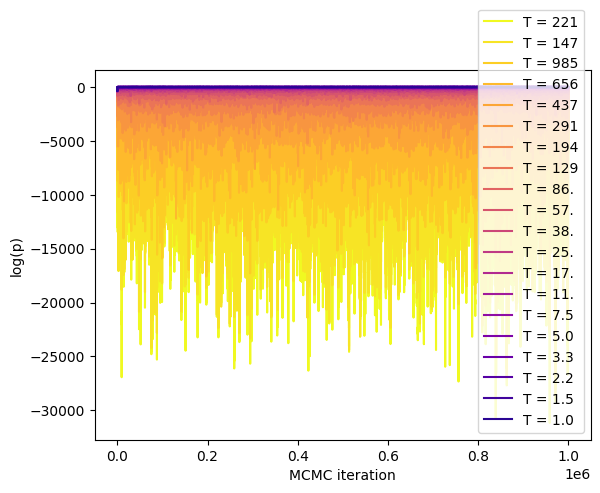

In [17]:
# plot log-pdf values
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))

for j, (temp, color) in enumerate(zip(temperature_ladder[::-1], chain_colors)):
    plt.plot(logpdfs[::-1][j] * temp, color=color, label=f'T = {str(temp)[:3]}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(p)')
plt.legend(loc='lower right')
plt.show()

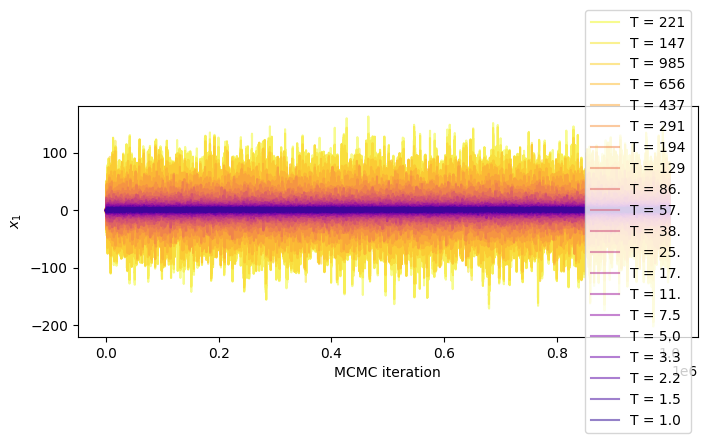

In [18]:
# make trace plot for particular parameter
param_ndx = 0
plt.figure(figsize=(8, 3))
for j in range(num_chains - 1, -1, -1):
    plt.plot(samples[j, :, param_ndx], color=chain_colors[::-1][j], alpha=0.5,
             label=f'T = {str(temperature_ladder[j])[:3]}')
plt.legend(loc='right')
plt.xlabel('MCMC iteration')
plt.ylabel(f'{x_labels[param_ndx]}')
plt.show()

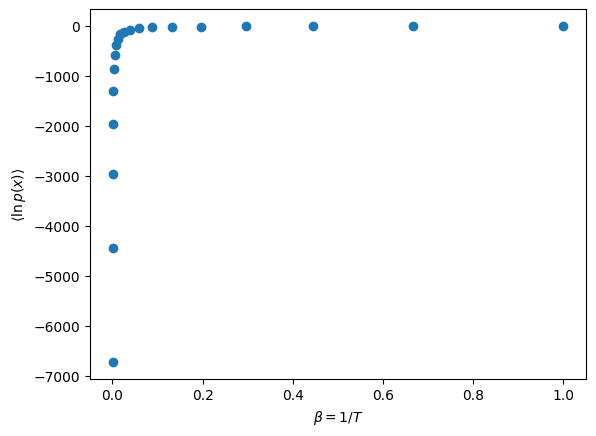

In [19]:
# plot average logpdf values
burnin = num_samples // 2
betas = 1. / temperature_ladder
avg_lnlikes = np.mean(logpdfs[:, burnin::10], axis=1) * temperature_ladder
plt.scatter(betas, avg_lnlikes)
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle \ln p(x) \rangle$')
plt.show()

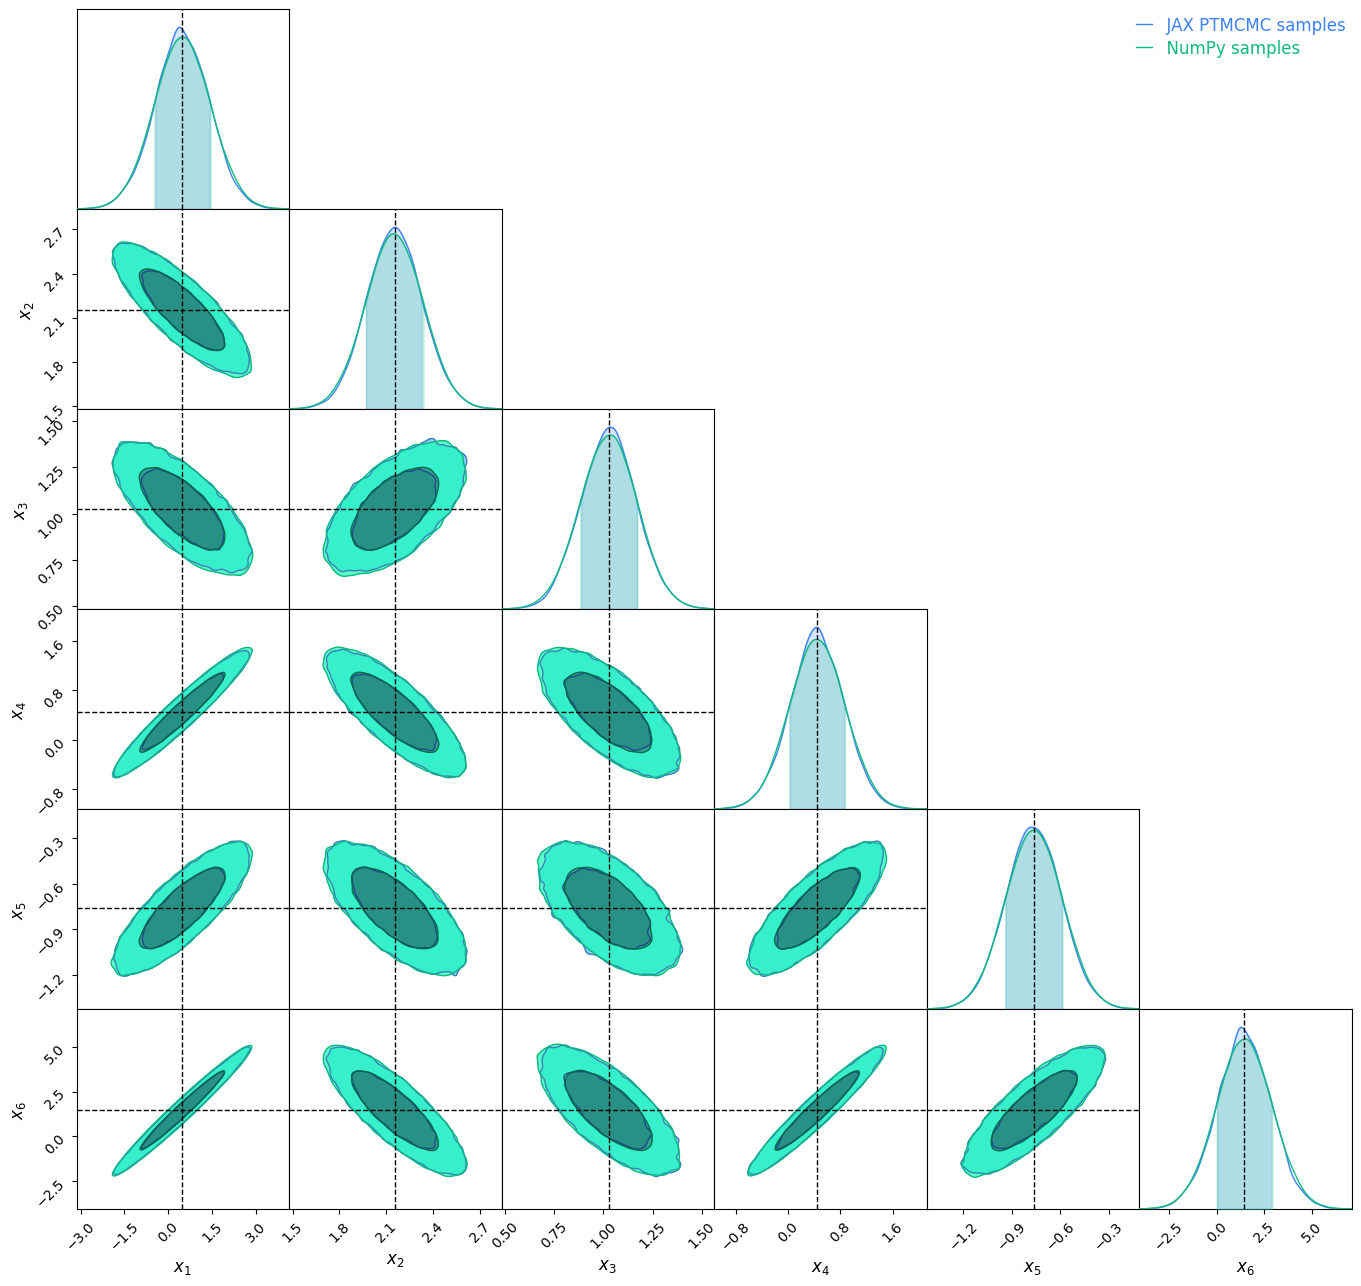

In [20]:
# draw from multivariate normal distribution with NumPy to compare
np_samples = np.random.multivariate_normal(mean, cov, 100_000)

# plot distribution
mv_df = pd.DataFrame(samples[0, burnin::10], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=mv_df, name='JAX PTMCMC samples'))
c.add_chain(Chain(samples=pd.DataFrame(np_samples, columns=x_labels), name='NumPy samples'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, mean)}))
fig = c.plotter.plot()